# Lab-10-1 Convolution

## 학습목표

합성곱 (Convolution) 연산에 대해 알아본다.

## 핵심키워드

합성곱 (Convolution) 연산  
필터(Filter)  
스트라이드(Stride)  
패딩(Padding)  
풀링(Pooling)  

## Convolution?

* 이미지 위에서 stride 값 만큼 filter(kernel)을 이동시키면서  
  겹쳐지는 부분의 각 원소의 값을 곱해서 모두 더한 값을 출력으로 하는 연산

## Stride and Padding

* stride: filter를 한번에 얼마나 이동 할 것인가
* padding: zero-padding (input + padding)

## 입력의 형태

* input type: torch.Tensor
* input shape: (N x X x H x W) (batch_size, channel, height, width)

## Convolution의 output 크기

$Output size = \frac{input size - filter size + (2 * padding)} {Stride} + 1$  

예제 1)  
input image size: 227 x227   
filter size = 11 x 11  
stride = 4  
padding = 0  
**output image size = ?**

In [2]:
import torch
import torch.nn as nn

# 예제 1
conv = nn.Conv2d(1, 1, 11, stride=4, padding=0)
inputs = torch.Tensor(1, 1, 227, 227)
out = conv(inputs)
out.shape

torch.Size([1, 1, 55, 55])

## Neuron과 Convolution
* Perceptron과 Convolution

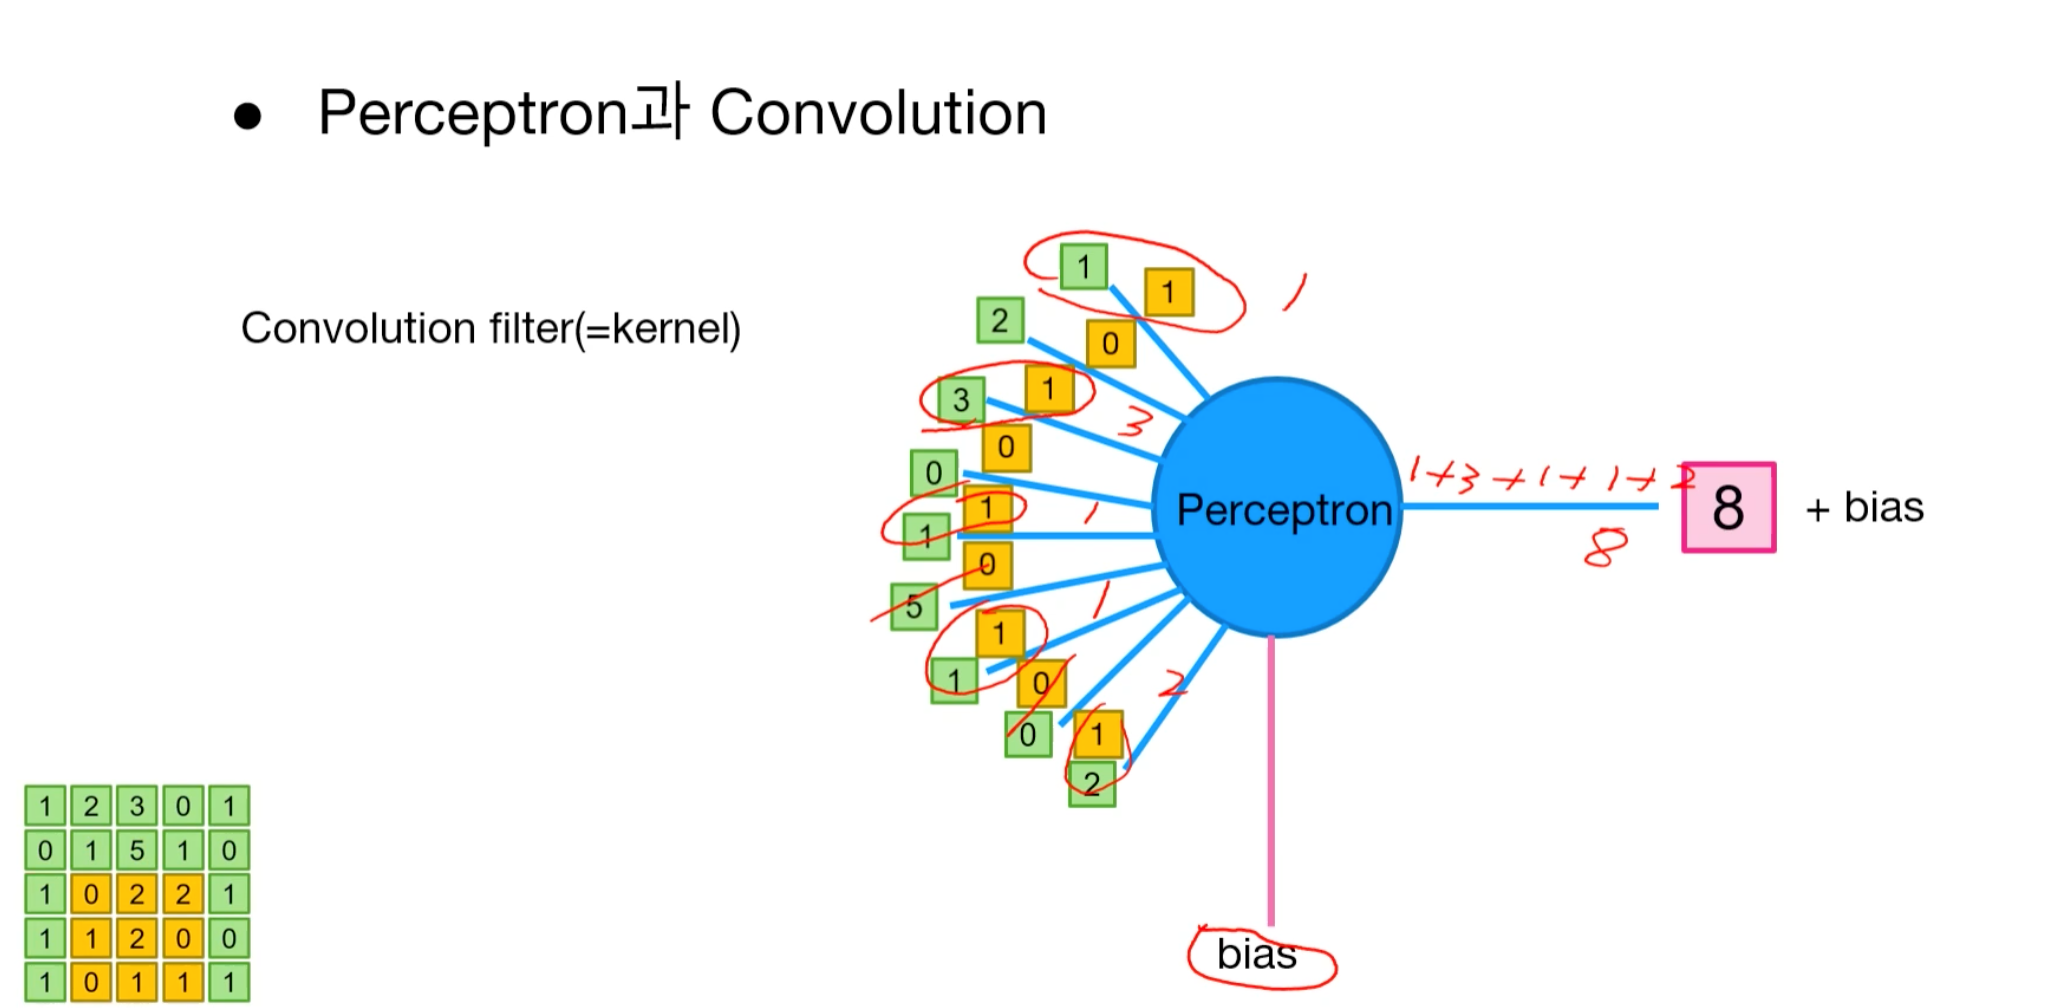

## Pooling

* Max Pooling
* Average Pooling

## CNN Implementation

* input 1 x 28 x 28  
* filter 5 x 5 x 5
* conv1 5 x 24 x 24
* pool1 5 x 12 x 12
* ouput 5 x 12 x 12

In [4]:
conv1 = nn.Conv2d(1, 5, 5)
pool = nn.MaxPool2d(2)

input = torch.Tensor(1, 1, 28, 28)
out = conv1(input)
out2 = pool(out)

print(out.size())
out2.size()

torch.Size([1, 5, 24, 24])


torch.Size([1, 5, 12, 12])

# Lab-10-2 Mnist CNN

## 학습목표

MNIST 데이터를 CNN으로 적용해본다. 

## 핵심키워드

딥러닝 학습 단계  
CNN  

## 학습 단계 (code 기준)

1. 라이브러리 가져오고 (torch, torchvision, matplotlib 같은것들)
2. GPU 사용 설정 하고 random value를 위한 seed 설정!
3. 학습에 사용되는 parameter 설정!(learning_rate, training_epochs, batch_size, etc)
4. 데이터셋을 가져오고 (학습에 쓰기 편하게) loader 만들기
5. 학습 모델 만들기( class CNN(torch.nn.Module) )
6. Loss function (Criterion)을 선택하고 최적화 도구 선택(optimizer)
7. 모델 학습 및 loss check(Criterion의 output)
8. 학습된 모델의 성능을 확인한다.

|라이브러리 가져오기|GPU 사용설정|데이터 셋을 가져오고 loader 만들기|Parameter 결정
|학습 모델 만들기|Loss function & Optimizer|Training|Test model Performance

## 우리가 만들 CNN 구조 확인

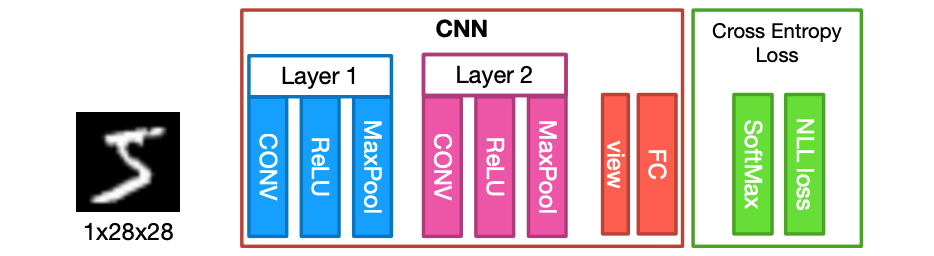

(Layer 1) Convolution layer = (in_c=1, out_c=32,kernel_size =3, stride=1,padding=1)  
(Layer 1) MaxPool layer = (kernel_size=2, stride =2)  
(Layer 2) Convolution layer = (in_c=32, out_c=64, kernel_size =3, stride=1,padding=1)  
(Layer 2) MaxPool layer = (kernel_size=2, stride =2)  

view => (batch_size x [7,7,64] => batch_size x [3136])  
Fully_Connect layer => (input=3136, output = 10)

In [15]:
import torch
import torch.nn as nn

input = torch.Tensor(1, 1, 28, 28)

conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
pool = nn.MaxPool2d(2)

out = pool(conv1(input))
out.shape

torch.Size([1, 32, 14, 14])

In [16]:
out = pool(conv2(out))
out.shape

torch.Size([1, 64, 7, 7])

In [18]:
out = out.view(out.size(0), -1)
out.shape

torch.Size([1, 3136])

In [19]:
fc = nn.Linear(3136, 10)
out = fc(out)
out.shape

torch.Size([1, 10])

## MNIST에 CNN 적용

In [20]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# random value 고정
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [21]:
# parameters
learning_rate = 1e-3
training_epochs = 15
batch_size = 100

In [22]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [24]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size = batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [37]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(7*7*64, 10, bias=True)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)

        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [38]:
model = CNN().to(device)

In [39]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
# traning
total_batch = len(data_loader)
print('Learning Started')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)

        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print(f'Epoch: {epoch+1} cost={avg_cost}')
print('Learning Finished!')

Learning Started
Epoch: 1 cost=0.06058944761753082
Epoch: 2 cost=0.043362103402614594
Epoch: 3 cost=0.03561806678771973
Epoch: 4 cost=0.029494009912014008
Epoch: 5 cost=0.025142131373286247
Epoch: 6 cost=0.02073376439511776
Epoch: 7 cost=0.017557863146066666
Epoch: 8 cost=0.015973402187228203
Epoch: 9 cost=0.012509212829172611
Epoch: 10 cost=0.010594435036182404
Epoch: 11 cost=0.009623393416404724
Epoch: 12 cost=0.008668559603393078
Epoch: 13 cost=0.007454639300704002
Epoch: 14 cost=0.006378001067787409
Epoch: 15 cost=0.006221125368028879
Learning Finished!


In [45]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9840999841690063


### 더 깊게 레이어 쌓기

In [67]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(3*3*128, 625)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(625, 10, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)
        # print(out.shape)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [68]:
model = CNN().to(device)

In [69]:
value = torch.Tensor(1, 1, 28, 28).to(device)
print(model(value).shape)

torch.Size([1, 10])


In [70]:
# traning
total_batch = len(data_loader)
print('Learning Started')

for epoch in range(training_epochs):
    avg_cost = 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)

        cost = criterion(hypothesis, y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print(f'Epoch: {epoch+1} cost={avg_cost}')
print('Learning Finished!')

Learning Started
Epoch: 1 cost=2.302821159362793
Epoch: 2 cost=2.302820920944214
Epoch: 3 cost=2.302821159362793
Epoch: 4 cost=2.302819013595581
Epoch: 5 cost=2.3028218746185303
Epoch: 6 cost=2.302820920944214
Epoch: 7 cost=2.3028206825256348
Epoch: 8 cost=2.3028199672698975
Epoch: 9 cost=2.302820920944214
Epoch: 10 cost=2.3028225898742676
Epoch: 11 cost=2.302820920944214
Epoch: 12 cost=2.302821636199951
Epoch: 13 cost=2.3028204441070557
Epoch: 14 cost=2.3028202056884766
Epoch: 15 cost=2.302820920944214
Learning Finished!


In [72]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.12790000438690186


# Lab-10-3 visdom

## 학습목표

Visdom 사용법을 익히고 MNIST-CNN 학습에 적용한다.

## 핵심키워드

Visdom 
CNN

In [ ]:
!pip install visdom

### Visdom 설치
```python
pip install visdom
```
### Visdom 서버 켜기
```python
python –m visdom.server
```

### Visdom 사용법
* Text  
* image  
* images
* Line plot

*visdom을 사용법을 익히고 MNIST-CNN loss graph까지 적용*

## Visdom Example

### Import Library

In [82]:
import torch
import torch.nn as nn

import torchvision
import torchvision.datasets as dsets

### Import Visdom

In [ ]:
import visdom
vis = visdom.Visdom()

Text

In [ ]:
vis.text("Hello world!", env="main")

In [ ]:
vis.close(env="main")

# Lab-10-4-1,2 ImageFolder1, ImageFolder2

## 학습목표

사용자 데이터를 사용하는 방법에 대해 알아본다. 

## 핵심키워드

Image Folder

## 진행순서

1. 나만의 데이터 셋 준비하기
2. torchvision.datasets.ImageFolder으로 불러오기
3. transforms 적용하여 저장 하기 origin_data -> train_data

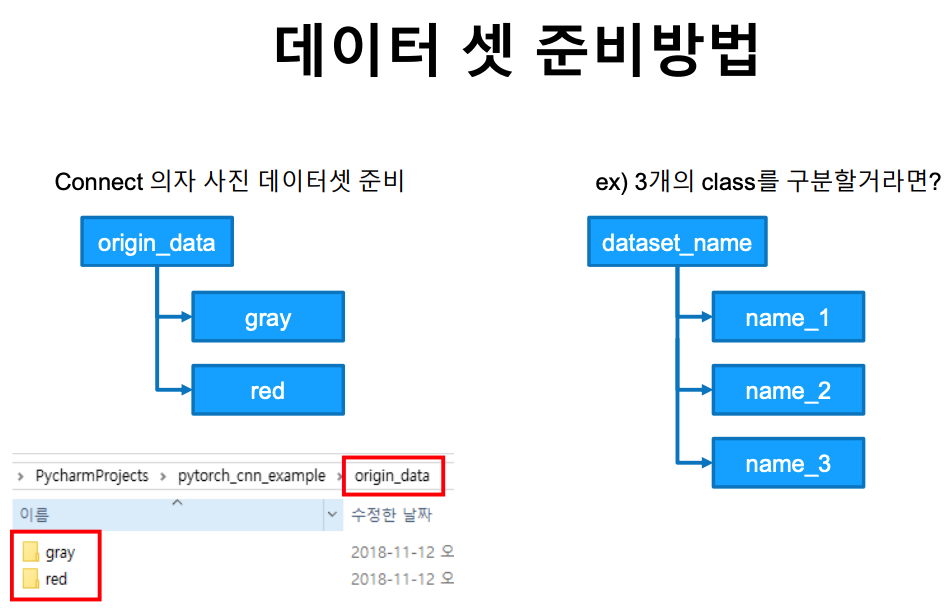

# Lab-10-6-1 Advanced CNN(RESNET-1)

## torchvision.models.resnet

* resnet (18,34,50,101,152)를 만들 수 있도록 되어있음  
* 3x224x224 입력을 기준으로 만들도록 되어 있음  
* input size가 다른 경우 ResNet를 적용하려면 어떻게 해야 할까?

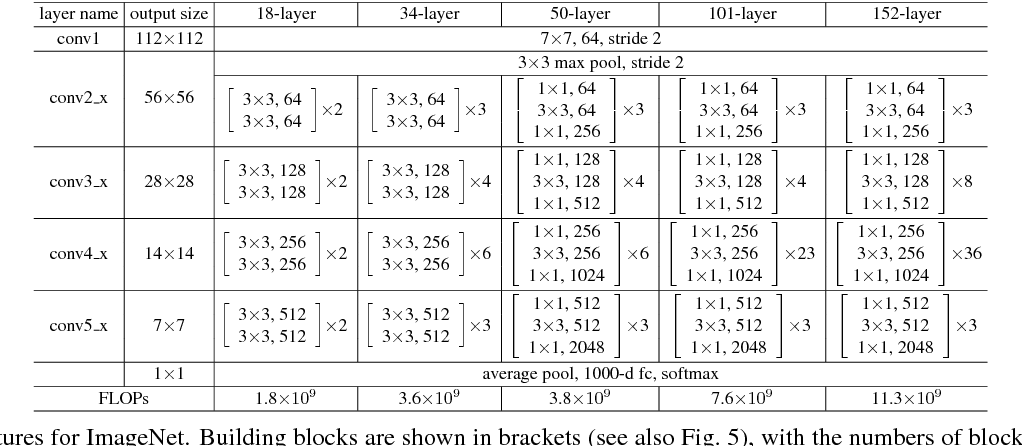

In [ ]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from ._utils import _ModelURLs

In [ ]:
__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
]

model_urls = _ModelURLs(
    {
        "resnet18": ResNet18_Weights.IMAGENET1K_V1.url,
        "resnet34": ResNet34_Weights.IMAGENET1K_V1.url,
        "resnet50": ResNet50_Weights.IMAGENET1K_V1.url,
        "resnet101": ResNet101_Weights.IMAGENET1K_V1.url,
        "resnet152": ResNet152_Weights.IMAGENET1K_V1.url,
        "resnext50_32x4d": ResNeXt50_32X4D_Weights.IMAGENET1K_V1.url,
        "resnext101_32x8d": ResNeXt101_32X8D_Weights.IMAGENET1K_V1.url,
        "wide_resnet50_2": Wide_ResNet50_2_Weights.IMAGENET1K_V1.url,
        "wide_resnet101_2": Wide_ResNet101_2_Weights.IMAGENET1K_V1.url,
    }
)


In [81]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [102]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        # x.shape = 3x64x64
        identity = x
        # identity = 3x64x64
        out = self.conv1(x)  # 3x3 stride = 2
        # out.shape = 3x32x32
        out = self.bn1(out)
        out = self.relu(out)
        # out.shape = 3x32x32
        out = self.conv2(out)  # 3x3 stride = 1 
        # out.shape = 3x32x32
        out = self.bn2(out)
        # out.shape = 3x32x32

        # out.shape = 3x32x32
        # identity = 3x64x64 -> 덧셈에 문제가 생김 -> downsample 진행
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)  # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)  # 3x3 stride = stride
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)  # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [113]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
def resnet18(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [2, 2, 2, 2], **kwargs)
    return model

In [106]:
def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

In [ ]:
res = resnet50()
res

# _log_api_usage_once 확인

In [108]:
import torchvision.models.resnet as resnet

In [110]:
res = resnet.resnet50()
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 